In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
from statsmodels.api import add_constant
import statsmodels.api as sm
import datasets
from tqdm import tqdm
from scipy.spatial.distance import cosine

In [2]:
model_names = ['SPECTER','SciBERT','SciNCL','Doc2Vec']

tasks_config = 'config/Doc2Vec/save.jsonl' # just choose one

model_eval_loc = 'results/{}/results.jsonl'

papers_loc = 'data/s2ag/processed/papers.parquet.gz'

depvars = ['i_5','i_10','cd_5','cd_10','betweenness_centrality_normalized_0hop_5', 'betweenness_centrality_normalized_0hop_10', 'pagerank_normalized_0hop_5', 
           'pagerank_normalized_0hop_10']

task_col_map = {'RELISH': ['ndcg'],
                'NFCorpus': ['ndcg'],
                'TREC-CoVID': ['ndcg'],
                'Peer Review Score': ['kendalltau'],
                'Max hIndex': ['kendalltau'],
                'Tweet Mentions': ['kendalltau'],
                'SciDocs MAG': ['f1_macro'],
                'SciDocs MeSH': ['f1_macro'],
                'SciDocs Cite': ['map','ndcg'],
                'SciDocs CoView': ['map','ndcg'],
                'SciDocs CoCite': ['map','ndcg'],
                'SciDocs CoRead': ['map','ndcg'],
                'Same Author Detection': ['map'],
                'Highly Influential Citations': ['map'],
                'Search': ['ndcg'],
                'Citation Count': ['kendalltau'],
                'Publication Year': ['kendalltau'],
                'MeSH': ['f1_macro'],
                }

depvar_name_map = {'i_5':'log(C5)',
                   'i_10':'log(C10)',
                   'cd_5':'CD5',
                   'cd_10':'CD10',
                   'betweenness_centrality_normalized_0hop_5':'Betweenness5',
                   'betweenness_centrality_normalized_0hop_10':'Betweenness10',
                   'pagerank_normalized_0hop_5':'PageRank5', 
                   'pagerank_normalized_0hop_10':'PageRank10',
                   }
                

In [3]:
## only run if you want to regenerate the scirepeval data and metadata
# dep = []
# for measure_name in depvars:
#     if 'cd' in measure_name:
#         measure_loc = f'data/s2ag/s2ag_disruption.parquet.gz'
#         impact = pd.read_parquet(measure_loc, columns=[measure_name, 'bcites_300']).reset_index().drop_duplicates(subset=['record_id'])
#         impact = impact.loc[impact['bcites_300'] > 0].set_index('record_id').drop(columns=['bcites_300'])
#     if 'i_' in measure_name:
#         measure_loc = f'data/s2ag/s2ag_disruption.parquet.gz'
#         impact = pd.read_parquet(measure_loc, columns=[measure_name]).reset_index().drop_duplicates(subset=['record_id']).set_index('record_id')
#     if 'centrality' in measure_name or 'pagerank' in measure_name:
#         measure_loc = f'data/s2ag/{measure_name}_1700-2022.csv.gz'
#         impact = pd.read_csv(measure_loc).rename(columns={'Unnamed: 0': 'record_id'}).drop_duplicates(subset=['record_id']).set_index('record_id')
#     dep.append(impact)
# deps = pd.concat(dep, axis=1)

# maps = []
# configs_seen = []
# with open(tasks_config, encoding="utf-8") as f:
#     for line in f:
#         d = json.loads(line)
#         meta = d['data']['meta']
#         if meta['config'] not in configs_seen:
#             ds = datasets.load_dataset(meta['name'], meta['config'])['evaluation'].to_pandas()
#             if 'query' in ds.columns:
#                 ds = pd.concat([ds.drop(['query'], axis=1), ds['query'].apply(pd.Series)], axis=1)
#             maps.append(ds)
#             configs_seen.append(meta['config'])

# map = pd.concat(maps)

# dfs = []
# for model_name in model_names:
#     eval_loc = model_eval_loc.format(model_name)
#     with open(eval_loc, 'rb') as f:
#         eval_data = json.load(f)
#         for task in eval_data.keys():
#             df = pd.DataFrame.from_dict(eval_data[task], orient='index', columns=task_col_map[task]).unstack().to_frame('loss')
#             df['task'] = task
#             df['model'] = model_name
#             df.index.names = ['metric','doc_id']
#             df = df.reset_index().merge(map[['corpus_id','doc_id','year']], on='doc_id')
#             dfs.append(df)

# df = pd.concat(dfs)

# merged = df.merge(deps, left_on='corpus_id', right_on='record_id')
# merged = merged.sort_values(by=['task','metric','model'])

# papers = pd.read_parquet(papers_loc)
# papers = papers[['corpusid','year','s2fieldsofstudy']]
# papers['field'] = papers['s2fieldsofstudy'].apply(lambda x: x[0]['category'] if x is not None else None)
# papers = papers.drop(columns=['s2fieldsofstudy'])

# merged = merged.merge(papers, left_on='corpus_id', right_on='corpusid')
# merged['year'] = merged['year_y']

In [4]:
merged = pd.read_parquet('data/s2ag/merged.parquet')
merged.head()

,metric,doc_id,loss,task,model,corpus_id,year_x,i_5,i_10,cd_5,cd_10,betweenness_centrality_normalized_0hop_5,betweenness_centrality_normalized_0hop_10,pagerank_normalized_0hop_5,pagerank_normalized_0hop_10,corpusid,year_y,field,year
0,kendalltau,16453849,2.993081,Citation Count,Doc2Vec,16453849.0,NaN,2.0,3.0,-0.040000,-0.011628,0.000000e+00,0.000000e+00,2.141475,2.193384,16453849,2016.0,Medicine,2016
1,kendalltau,116288738,1.824496,Citation Count,Doc2Vec,116288738.0,NaN,1.0,1.0,NaN,NaN,0.000000e+00,0.000000e+00,1.169488,1.149221,116288738,2016.0,Environmental Science,2016
2,kendalltau,2773941,0.140252,Citation Count,Doc2Vec,2773941.0,NaN,37.0,40.0,-0.014818,-0.007390,0.000000e+00,6.241591e-10,4.906337,4.515546,2773941,2016.0,Environmental Science,2016
3,kendalltau,36986694,1.496946,Citation Count,Doc2Vec,36986694.0,NaN,1.0,1.0,-0.000366,-0.000213,9.459118e-08,2.239780e-07,7.639057,8.366757,36986694,2016.0,Business,2016
4,kendalltau,2627267,-1.349620,Citation Count,Doc2Vec,2627267.0,NaN,32.0,36.0,-0.002852,-0.001501,0.000000e+00,7.772966e-09,5.224954,4.891785,2627267,2016.0,Computer Science,2016


In [5]:
# # only run if you want to recreate the embeddings by model and task parquet file 
# def load_embeddings_from_jsonl(embeddings_path: str):
#     embeddings = {}
#     with open(embeddings_path, 'r') as f:
#         for line in tqdm(f, desc=f'reading embeddings from {embeddings_path}'):
#             line_json = json.loads(line)
#             embeddings[line_json['doc_id']] = np.array(line_json['embedding'], dtype=np.float64)
#     return embeddings

# embds = {}
# for model_name in model_names:
#     e = {}
#     for root, dirs, files in os.walk(os.path.join('20240626',model_name)):
#         for file in files:
#             if file.endswith('.jsonl'):
#                 file_path = os.path.join(root, file)
#                 e = {**e, **load_embeddings_from_jsonl(file_path)}
#             embds[model_name] = e

# df_embds = pd.DataFrame(embds).stack().to_frame('embedding')
# df_embds.head()

In [6]:
df_embds = pd.read_parquet('data/s2ag/scirepeval_embeddings_by_model.parquet.gz')
df_embds.head()

embedding
doc_id   model                                                     
35959927 SPECTER  [1.136360764503479, 0.16112475097179413, 0.230...
         SciBERT  [1.0984188318252563, 0.1899947226047516, 0.603...
         SciNCL   [1.2763468027114868, -0.4045873284339905, -0.0...
         Doc2Vec  [-0.45157599449157715, 0.4587252140045166, -0....
5014899  SPECTER  [0.7647122144699097, 0.4409884810447693, -0.58...

In [7]:
df_embds = df_embds.reset_index().rename(columns={'level_0':'doc_id','level_1':'model'})
df_merged = merged.merge(df_embds, on=['doc_id','model'])
# df_merged['embedding'] = df_merged['embedding'].apply(lambda x: x.astype(np.float64))
df_merged.head()

,metric,doc_id,loss,task,model,corpus_id,year_x,i_5,i_10,cd_5,cd_10,betweenness_centrality_normalized_0hop_5,betweenness_centrality_normalized_0hop_10,pagerank_normalized_0hop_5,pagerank_normalized_0hop_10,corpusid,year_y,field,year,embedding
0,kendalltau,16453849,2.993081,Citation Count,Doc2Vec,16453849.0,NaN,2.0,3.0,-0.040000,-0.011628,0.000000e+00,0.000000e+00,2.141475,2.193384,16453849,2016.0,Medicine,2016,"[-0.543255090713501, 1.3463175296783447, -0.15..."
1,kendalltau,116288738,1.824496,Citation Count,Doc2Vec,116288738.0,NaN,1.0,1.0,NaN,NaN,0.000000e+00,0.000000e+00,1.169488,1.149221,116288738,2016.0,Environmental Science,2016,"[0.16532737016677856, 0.5417365431785583, 0.04..."
2,kendalltau,2773941,0.140252,Citation Count,Doc2Vec,2773941.0,NaN,37.0,40.0,-0.014818,-0.007390,0.000000e+00,6.241591e-10,4.906337,4.515546,2773941,2016.0,Environmental Science,2016,"[0.8442239761352539, 0.1162882000207901, 0.210..."
3,kendalltau,36986694,1.496946,Citation Count,Doc2Vec,36986694.0,NaN,1.0,1.0,-0.000366,-0.000213,9.459118e-08,2.239780e-07,7.639057,8.366757,36986694,2016.0,Business,2016,"[-0.02126144990324974, 0.13658781349658966, -0..."
4,kendalltau,2627267,-1.349620,Citation Count,Doc2Vec,2627267.0,NaN,32.0,36.0,-0.002852,-0.001501,0.000000e+00,7.772966e-09,5.224954,4.891785,2627267,2016.0,Computer Science,2016,"[0.5156078934669495, 0.3397905230522156, 0.120..."


In [8]:
df_mean = df_merged.groupby(['task','model'])['embedding'].mean().to_frame('mean_embedding')
df_mean.head()

mean_embedding
task                         model                                                     
Citation Count               Doc2Vec  [0.013351456303917774, 0.3526229039022089, -0....
                             SPECTER  [0.3439091747078713, 0.42703024869798495, -0.2...
                             SciBERT  [0.23981928801085567, -0.31196981458594214, -0...
                             SciNCL   [-0.07894579403095361, -0.04261863096507133, -...
Highly Influential Citations Doc2Vec  [-0.025601796112835803, 0.3101684627146382, -0...

In [9]:
df_merged = df_merged.merge(df_mean, left_on=['task','model'], right_index=True)
df_merged.head()

,metric,doc_id,loss,task,model,corpus_id,year_x,i_5,i_10,cd_5,...,betweenness_centrality_normalized_0hop_5,betweenness_centrality_normalized_0hop_10,pagerank_normalized_0hop_5,pagerank_normalized_0hop_10,corpusid,year_y,field,year,embedding,mean_embedding
0,kendalltau,16453849,2.993081,Citation Count,Doc2Vec,16453849.0,NaN,2.0,3.0,-0.040000,...,0.000000e+00,0.000000e+00,2.141475,2.193384,16453849,2016.0,Medicine,2016,"[-0.543255090713501, 1.3463175296783447, -0.15...","[0.013351456303917774, 0.3526229039022089, -0...."
1,kendalltau,116288738,1.824496,Citation Count,Doc2Vec,116288738.0,NaN,1.0,1.0,NaN,...,0.000000e+00,0.000000e+00,1.169488,1.149221,116288738,2016.0,Environmental Science,2016,"[0.16532737016677856, 0.5417365431785583, 0.04...","[0.013351456303917774, 0.3526229039022089, -0...."
2,kendalltau,2773941,0.140252,Citation Count,Doc2Vec,2773941.0,NaN,37.0,40.0,-0.014818,...,0.000000e+00,6.241591e-10,4.906337,4.515546,2773941,2016.0,Environmental Science,2016,"[0.8442239761352539, 0.1162882000207901, 0.210...","[0.013351456303917774, 0.3526229039022089, -0...."
3,kendalltau,36986694,1.496946,Citation Count,Doc2Vec,36986694.0,NaN,1.0,1.0,-0.000366,...,9.459118e-08,2.239780e-07,7.639057,8.366757,36986694,2016.0,Business,2016,"[-0.02126144990324974, 0.13658781349658966, -0...","[0.013351456303917774, 0.3526229039022089, -0...."
4,kendalltau,2627267,-1.349620,Citation Count,Doc2Vec,2627267.0,NaN,32.0,36.0,-0.002852,...,0.000000e+00,7.772966e-09,5.224954,4.891785,2627267,2016.0,Computer Science,2016,"[0.5156078934669495, 0.3397905230522156, 0.120...","[0.013351456303917774, 0.3526229039022089, -0...."


In [10]:
df_merged['novelty'] = df_merged.apply(lambda x: cosine(x['embedding'], x['mean_embedding']), axis=1)
df_merged.head()

,metric,doc_id,loss,task,model,corpus_id,year_x,i_5,i_10,cd_5,...,betweenness_centrality_normalized_0hop_10,pagerank_normalized_0hop_5,pagerank_normalized_0hop_10,corpusid,year_y,field,year,embedding,mean_embedding,novelty
0,kendalltau,16453849,2.993081,Citation Count,Doc2Vec,16453849.0,NaN,2.0,3.0,-0.040000,...,0.000000e+00,2.141475,2.193384,16453849,2016.0,Medicine,2016,"[-0.543255090713501, 1.3463175296783447, -0.15...","[0.013351456303917774, 0.3526229039022089, -0....",0.526775
1,kendalltau,116288738,1.824496,Citation Count,Doc2Vec,116288738.0,NaN,1.0,1.0,NaN,...,0.000000e+00,1.169488,1.149221,116288738,2016.0,Environmental Science,2016,"[0.16532737016677856, 0.5417365431785583, 0.04...","[0.013351456303917774, 0.3526229039022089, -0....",0.632331
2,kendalltau,2773941,0.140252,Citation Count,Doc2Vec,2773941.0,NaN,37.0,40.0,-0.014818,...,6.241591e-10,4.906337,4.515546,2773941,2016.0,Environmental Science,2016,"[0.8442239761352539, 0.1162882000207901, 0.210...","[0.013351456303917774, 0.3526229039022089, -0....",0.627274
3,kendalltau,36986694,1.496946,Citation Count,Doc2Vec,36986694.0,NaN,1.0,1.0,-0.000366,...,2.239780e-07,7.639057,8.366757,36986694,2016.0,Business,2016,"[-0.02126144990324974, 0.13658781349658966, -0...","[0.013351456303917774, 0.3526229039022089, -0....",0.505240
4,kendalltau,2627267,-1.349620,Citation Count,Doc2Vec,2627267.0,NaN,32.0,36.0,-0.002852,...,7.772966e-09,5.224954,4.891785,2627267,2016.0,Computer Science,2016,"[0.5156078934669495, 0.3397905230522156, 0.120...","[0.013351456303917774, 0.3526229039022089, -0....",0.459204


In [11]:
quantiles = 4
df_merged['novelty quantile'] = df_merged['novelty'].transform(lambda x: pd.qcut(x, q=quantiles, duplicates='drop', labels=False)) + 1
df_merged['highly_novel'] = df_merged['novelty quantile'] == 4

df_merged['highly_novel_75'] = (df_merged['novelty'] > 
                                df_merged.groupby(['task','model'])['novelty'].transform(lambda x: x.quantile(0.75)))
                                
df_merged['highly_novel_90'] = (df_merged['novelty'] > 
                                df_merged.groupby(['task','model'])['novelty'].transform(lambda x: x.quantile(0.90)))

df_merged['highly_novel_95'] = (df_merged['novelty'] > 
                                df_merged.groupby(['task','model'])['novelty'].transform(lambda x: x.quantile(0.95)))

df_merged['highly_novel_99'] = (df_merged['novelty'] > 
                                df_merged.groupby(['task','model'])['novelty'].transform(lambda x: x.quantile(0.99)))

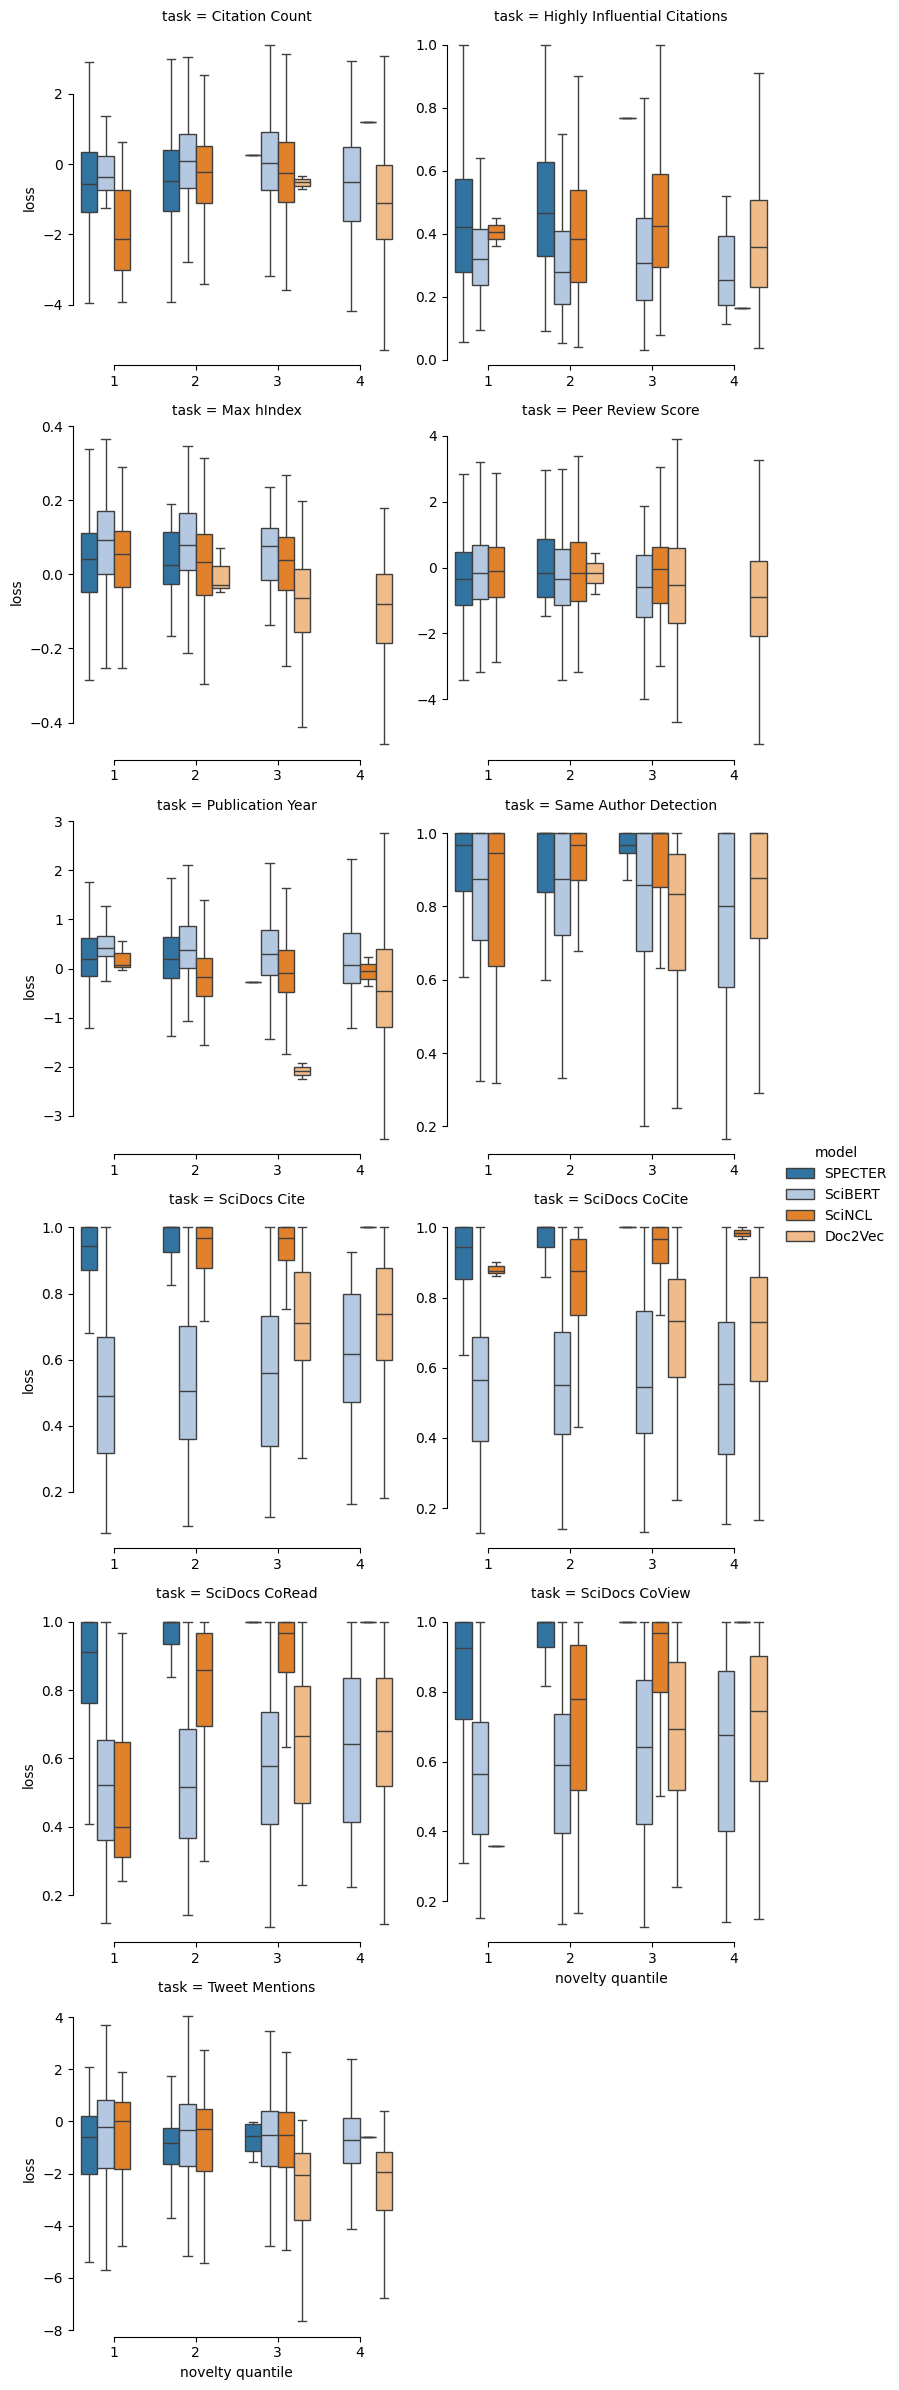

In [12]:
sns.catplot(x="novelty quantile", y="loss",
            hue="model", col="task", col_wrap=2,
            kind='box', sharey=False, showfliers=False,
            data=df_merged[~df_merged['metric'].isin(['f1_macro', 'ndcg'])], palette='tab20',
            height=4)
sns.despine(offset=0, trim=True)
plt.show()

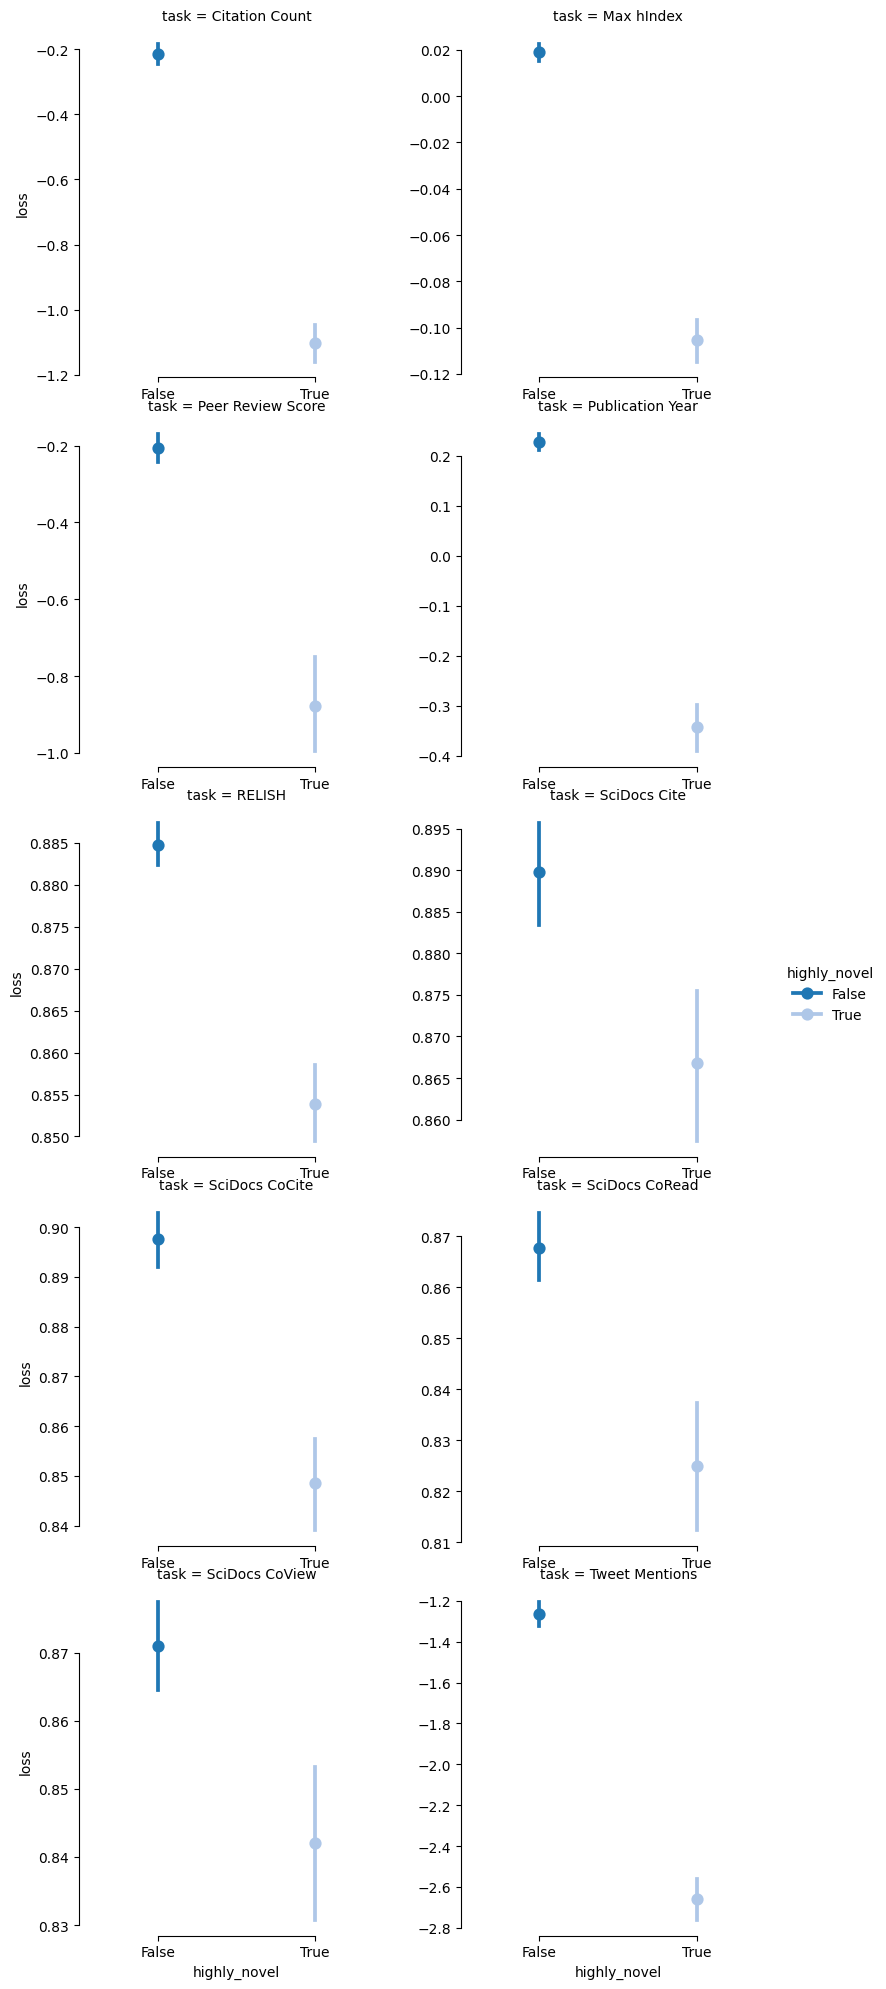

In [13]:
sns.catplot(x="highly_novel", y="loss",
            hue="highly_novel", col="task", col_wrap=2,
            kind='point', sharey=False,
            data=df_merged[~df_merged['metric'].isin(['f1_macro', 'map'])], palette='tab20',
            height=4)
sns.despine(offset=0, trim=True)
# plt.suptitle('5 Betweenness', y=1.05, x=0.45)
plt.show()

In [14]:
# run regressions

df_merged['year'] = df_merged['year'].astype(int)
panel = df_merged.dropna(subset=['year','field'])
panel = panel.set_index(['field', 'year'])
models = model_names + ['All']
ivars = ['novelty', 'highly_novel_75', 'highly_novel_90', 'highly_novel_95', 'highly_novel_99']

reg_results = []
# all models
for modelname in tqdm(models):
    for task in [t for t in panel['task'].unique() if t not in ['SciDocs MAG', 'SciDocs MeSH', 'MeSH']]:
        for ivar in ivars:
            if modelname == 'All':
                tp = panel[panel['task'] == task]
            else:
                tp = panel[(panel['task'] == task) & (panel['model'] == modelname)]
            model = PanelOLS(tp['loss'], add_constant(tp[ivar]), entity_effects=True, time_effects=True)
            results = model.fit()
        
            res = {'model': modelname,
                'task': task, 
                'depvar': 'loss', 
                'ivar': ivar,
                'r2': results.rsquared, 
                'f': results.f_statistic.stat, 
                'f_pvalue': results.f_statistic.pval, 
                'n': results.nobs,
                }
            param_res = {k + '_param': v for k, v in results.params.to_dict().items()}
            pval_res = {k + '_pvalue': v for k, v in results.pvalues.to_dict().items()}
            cis = {k + '_novelty': v[ivar] for k, v in results.conf_int().to_dict().items()}
            reg_results.append({**res, **param_res, **pval_res, **cis})
        
                
reg_results = pd.DataFrame(reg_results)
reg_results.head()

 80%|████████  | 4/5 [00:25<00:06,  6.28s/it]

100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


,model,task,depvar,ivar,r2,f,f_pvalue,n,const_param,novelty_param,...,lower_novelty,upper_novelty,highly_novel_75_param,highly_novel_75_pvalue,highly_novel_90_param,highly_novel_90_pvalue,highly_novel_95_param,highly_novel_95_pvalue,highly_novel_99_param,highly_novel_99_pvalue
0,SPECTER,Citation Count,loss,novelty,0.004400,12.457394,0.000423,2855,-1.147113,5.864743,...,2.606601,9.122885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SPECTER,Citation Count,loss,highly_novel_75,0.000857,2.416713,0.120159,2855,-0.525482,NaN,...,-0.024367,0.210868,0.093251,0.120159,NaN,NaN,NaN,NaN,NaN,NaN
2,SPECTER,Citation Count,loss,highly_novel_90,0.000032,0.091477,0.762330,2855,-0.504765,NaN,...,-0.144339,0.196989,NaN,NaN,0.026325,0.76233,NaN,NaN,NaN,NaN
3,SPECTER,Citation Count,loss,highly_novel_95,0.000062,0.173802,0.676786,2855,-0.499665,NaN,...,-0.278582,0.180891,NaN,NaN,NaN,NaN,-0.048845,0.676786,NaN,NaN
4,SPECTER,Citation Count,loss,highly_novel_99,0.000003,0.009398,0.922779,2855,-0.501879,NaN,...,-0.521857,0.472686,NaN,NaN,NaN,NaN,NaN,NaN,-0.024585,0.922779


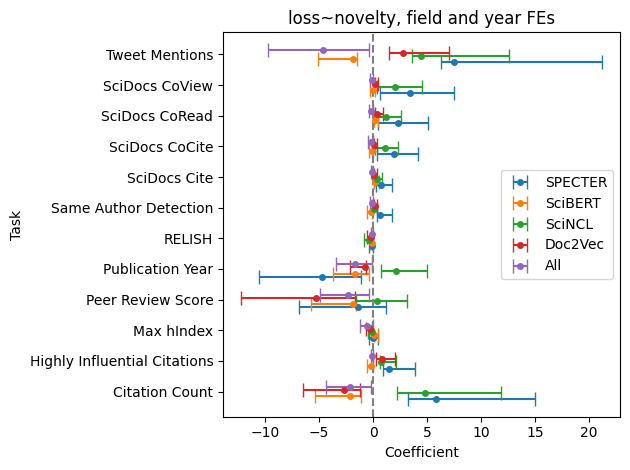

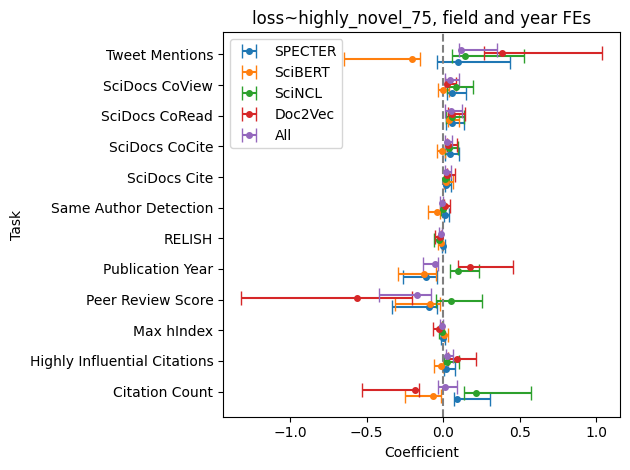

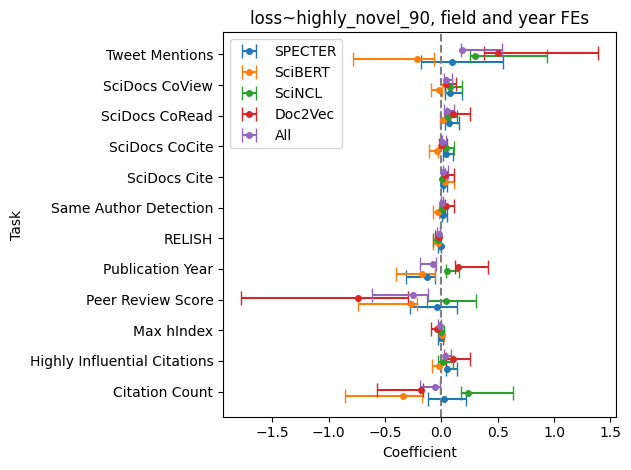

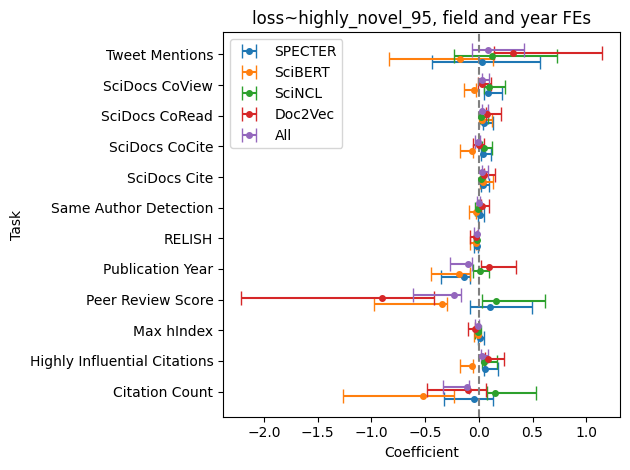

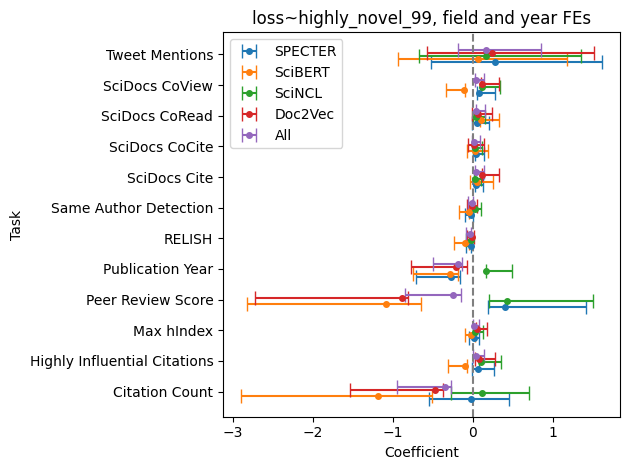

In [15]:
# make confidence interval plot

offset = 0.5  # Define the offset for vertical separation of error bars
spacing_factor = 5

# Create a mapping from task to numerical y positions
unique_tasks = reg_results['task'].unique()
task_to_num = {task: spacing_factor*i for i, task in enumerate(unique_tasks)}

for ivar in reg_results['ivar'].unique():
    for depvar in reg_results['depvar'].unique():
        fig, ax = plt.subplots()
        num_models = len(models)
        for i, modelname in enumerate(models): 
            df = reg_results[(reg_results['depvar'] == depvar) & (reg_results['model'] == modelname) & (reg_results['ivar'] == ivar)]
            midpoints = df[f'{ivar}_param']
            yerr = [df['lower_novelty'].abs(), df['upper_novelty'].abs()]
            
            # Map tasks to numerical positions and apply vertical offset
            y_positions = df['task'].map(task_to_num) + (i - num_models / 2) * offset

            # Plot the intervals using error bars
            ax.errorbar(midpoints, y_positions, xerr=yerr, fmt='o', capsize=5, label=modelname, markersize=4)

        # Plot the zero line
        ax.axvline(x=0, color='gray', linestyle='--')

        # Set y-axis ticks and labels to be the original task names
        ax.set_yticks(spacing_factor*np.arange(len(unique_tasks)))
        ax.set_yticklabels(unique_tasks)

        # Adding labels and title
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Task')
        ax.set_title(f'loss~{ivar}, field and year FEs')
        ax.legend()

        plt.tight_layout()
        # Display the plot
        plt.show()


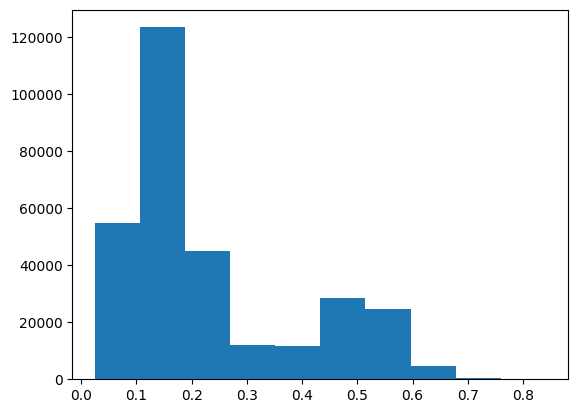

In [16]:
plt.hist(df_merged['novelty'])
plt.show()